Today we'll once again continue where we left off.  Some general goals for this project:

*  Follow the [Bioconductor OSCA Basics Book](http://bioconductor.org/books/3.16/OSCA.basic/)
*  Maybe re-assemble from the FASTQ files using the new chicken assembly in Ensembl

I'd like to go through today and practice <b style="color:#537FBF">Feature Selection</b> and <b style="color:#537FBF">Dimensionality Reduction</b>.

<details>
    <summary><b style="color:#C0CF96">Set up utility functions</b></summary>
    
In the future I'll split these off into a utility file.

In [110]:
set.seed(0)
library(SingleCellExperiment)
library(scran)
library(scater)
library(dplyr)
library(biomaRt)
library(sparseMatrixStats)

In [111]:
load.scea.data <- function(dir.path, exp.name) {
    # Load in the matrix of counts
    counts.mat <- Matrix::readMM(
        paste0(
            dir.path,
            exp.name, '-quantification-raw-files/',
            exp.name, '.aggregated_filtered_counts.mtx'
        )
    ) |> as(Class="CsparseMatrix")
    
    # Get the gene names for the matrix
    counts.rows <- read.csv(
        paste0(
            dir.path,
            exp.name, '-quantification-raw-files/',
            exp.name, '.aggregated_filtered_counts.mtx_rows'
        ),
        sep='\t',
        header=FALSE
    )$V1

    # Get the cell ids for the matrix
    counts.cols <- read.csv(
        paste0(
            dir.path,
            exp.name, '-quantification-raw-files/',
            exp.name, '.aggregated_filtered_counts.mtx_cols'
        ),
        sep='\t',
        header=FALSE
    )$V1
    
    # Get all cellwise metadata
    meta.data <- read.csv(
        paste0(
            dir.path,
            'ExpDesign-', exp.name, '.tsv'
        ),
        sep='\t',
        header=TRUE,
        row.names='Assay'
    )
    
    rownames(counts.mat) <- counts.rows
    colnames(counts.mat) <- counts.cols
    
    # Ensure that the meta.data lines up with the cells
    if (!identical(rownames(meta.data), colnames(counts.mat))) {
        warning("The metadata does not line up with the cells")
    }
    
    return(
        SingleCellExperiment(
            assays=list(counts=counts.mat),
            colData=meta.data
        )
    )
}

add.hgnc.names <- function(sce, mart) {
    rowData(sce) <- getBM(
        filters="ensembl_gene_id",
        attributes=c(
            "ensembl_gene_id",
            "hgnc_symbol"
        ),
        values=rownames(sce),
        mart=mart
    )
    return(sce)
}

add.mito.info <- function(sce) {
    rowSubset(sce, field="is.mito") <- grep("MT-", rowData(sce)$hgnc_symbol)
    return(sce)
}

In [112]:
mart <- useDataset(
    "ggallus_gene_ensembl",
    useMart(
        "ensembl",
        host="https://apr2022.archive.ensembl.org"
    )
)

sce <- load.scea.data("./localdata/Datasets/E-CURD-13/", "E-CURD-13")

</details>

After setting up our utility functions, it's pretty easy to catch up to where we were yesterday:

In [113]:
mart <- useDataset(
    "ggallus_gene_ensembl",
    useMart(
        "ensembl",
        host="https://apr2022.archive.ensembl.org"
    )
)
sce <- load.scea.data("./localdata/Datasets/E-CURD-13/", "E-CURD-13") |>
    add.hgnc.names(mart=mart) |>
    add.mito.info() |>
    quickPerCellQC(subsets=list(Mito=is.mito), sub.fields="subsets_Mito_percent") |>
    logNormCounts()

In [114]:
sce

class: SingleCellExperiment 
dim: 13645 7430 
metadata(0):
assays(2): counts logcounts
rownames(13645): ENSGALG00000000003 ENSGALG00000000011 ...
  ENSGALG00000055127 ENSGALG00000055132
rowData names(3): ensembl_gene_id hgnc_symbol is.mito
colnames(7430): SAMN11526603-AAAAAAATTCAG SAMN11526603-AAAAACAAGTAG ...
  SAMN11526603-TTTTTTTGTGAG SAMN11526603-TTTTTTTTTTTT
colData names(29): Sample.Characteristic.organism.
  Sample.Characteristic.Ontology.Term.organism. ... discard sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

We're now going to find information on the variance of the genes, for feature selection.  The OSCA book makes the following plot:

In [132]:
gene.var.data <- modelGeneVar(sce)
md <- metadata(gene.var.data)
md.as.df <- data.frame(mean=md$mean, var=md$var)

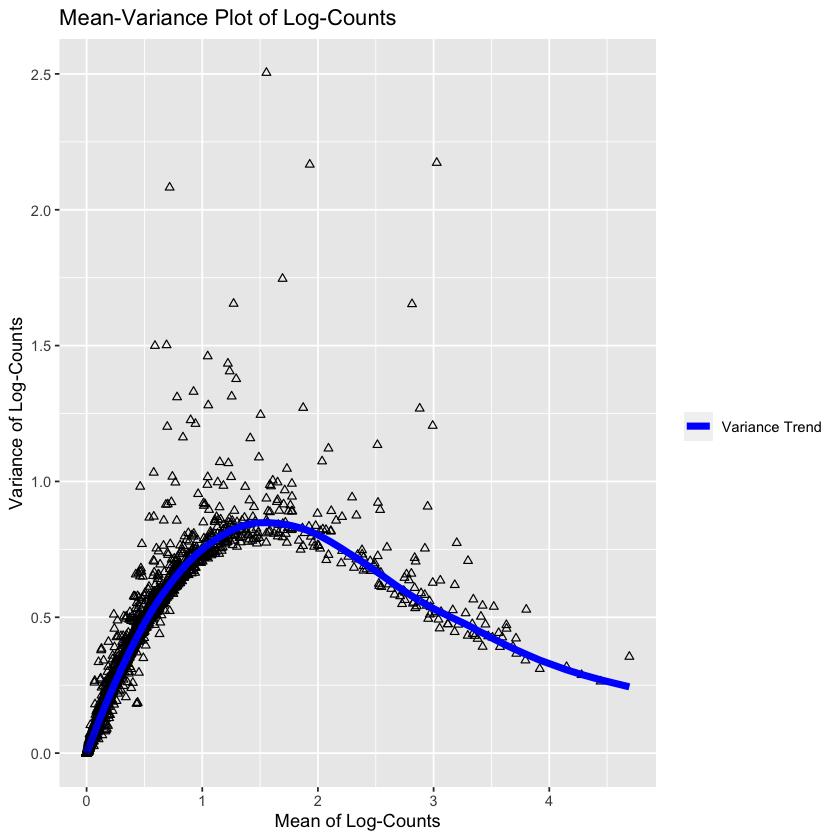

In [133]:
ggplot(md.as.df, aes(mean, var)) +
    geom_point(shape=2) +
    geom_line(
        aes(mean, md$trend(mean), lty='Variance Trend'),
        color="blue",
        linewidth=2,
    ) +
    labs(
        x="Mean of Log-Counts",
        y="Variance of Log-Counts"
    ) +
    ggtitle("Mean-Variance Plot of Log-Counts") +
    scale_linetype("") # This changes the legend title for some reason

This plot is showing the mean-variance trend of the logs.  The trend is assumed to be the 'uninteresting variation', i.e. the baseline variation of the experiment (assumed to be the technical variation and the 'boring' biological variation).  Under this assumption, the deviation from this trend represents the interesting biological variation.

But speaking of mean-variance trends, this reminds me of the fact that Poisson distributions have equal mean and variance; it's reasonable to believe that our original (non-log) counts follow a Poisson distribution: is this correct?

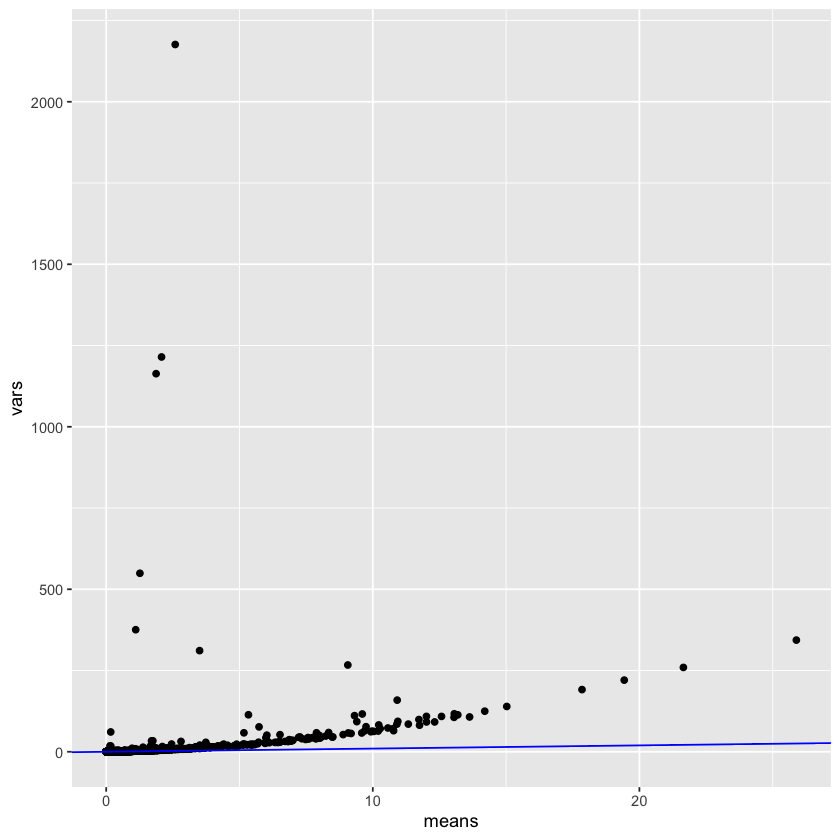

In [134]:
means <- rowMeans(assay(sce, "counts"))
vars <- rowVars(assay(sce, "counts"))

ggplot(
    data.frame(
        means=means,
        vars=vars
    ),
    aes(
        x=means,
        y=vars
    )
) +
    geom_point() +
    geom_abline(slope=1, color='blue')

Interestingly, this is not accurate at all!  The variance is way higher than the means.  This could be because the counts have already been scaled by a value.  I'll have a think about this for the future.  I did discover the `modelGeneVarByPoisson` function, so let's see what that does:

In [143]:
gene.var.data <- modelGeneVarByPoisson(sce)
md <- metadata(gene.var.data)
md.as.df <- data.frame(mean=md$mean, var=md$var)

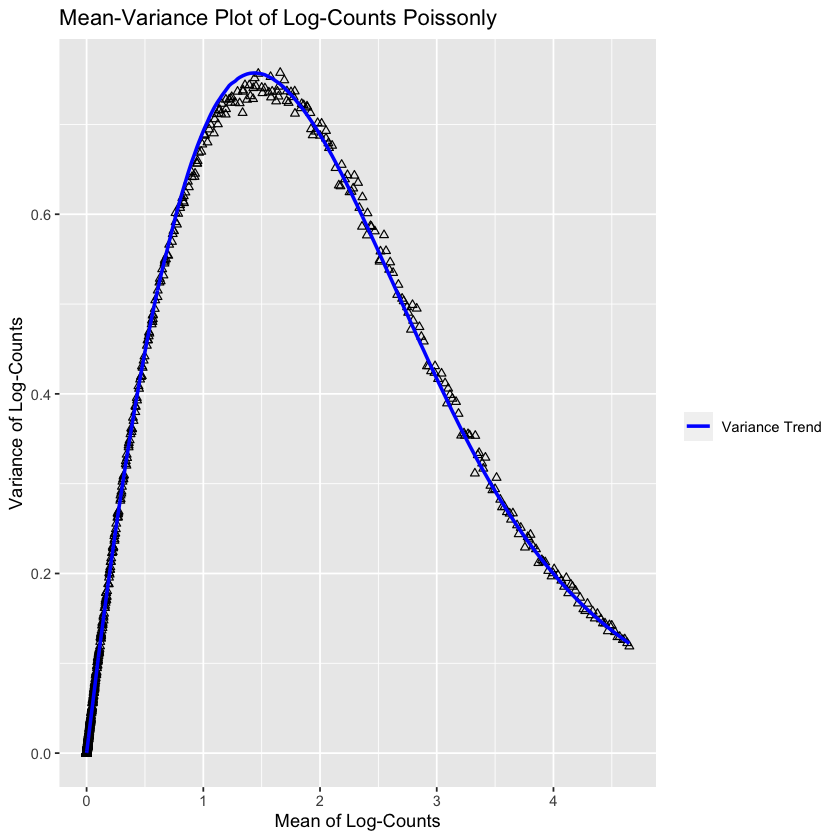

In [146]:
ggplot(md.as.df, aes(mean, var)) +
    geom_point(shape=2) +
    geom_line(
        aes(mean, md$trend(mean), lty='Variance Trend'),
        color="blue",
        linewidth=1,
    ) +
    labs(
        x="Mean of Log-Counts",
        y="Variance of Log-Counts"
    ) +
    ggtitle("Mean-Variance Plot of Log-Counts Poissonly") +
    scale_linetype("") # This changes the legend title for some reason

Interestingly enough, this looks very accurate!  So it's plausible that I messed up somewhere in my prior plot.  Of course, I don't really understand what this plot represents at the moment - but it's clear the predicted trend deviates somewhat from the true trend at the maximum (it oversetimates it).

For completeness, let's peek at the most varying genes!

In [142]:
genes.by.variance <- gene.var.data[order(gene.var.data$bio, decreasing=TRUE),]
head(genes.by.variance)

DataFrame with 6 rows and 6 columns
                        mean     total      tech       bio      p.value
                   <numeric> <numeric> <numeric> <numeric>    <numeric>
ENSGALG00000037167  1.554552   2.50414  0.848294  1.655847 3.16059e-154
ENSGALG00000035998  3.027209   2.17292  0.525832  1.647090  0.00000e+00
ENSGALG00000046616  0.717956   2.08196  0.619730  1.462226 3.02326e-224
ENSGALG00000010745  1.929346   2.16633  0.816513  1.349819 2.86377e-111
ENSGALG00000052192  2.813587   1.65282  0.577865  1.074959 2.77975e-140
ENSGALG00000015970  0.590967   1.49926  0.542383  0.956873 2.09606e-126
                            FDR
                      <numeric>
ENSGALG00000037167 8.62525e-151
ENSGALG00000035998  0.00000e+00
ENSGALG00000046616 1.03131e-220
ENSGALG00000010745 2.60508e-108
ENSGALG00000052192 5.41853e-137
ENSGALG00000015970 3.17786e-123

In [149]:
rowData(sce[rownames(sce) == "ENSGALG00000037167"])$hgnc_symbol
rowData(sce[rownames(sce) == "ENSGALG00000035998"])$hgnc_symbol
rowData(sce[rownames(sce) == "ENSGALG00000046616"])$hgnc_symbol
rowData(sce[rownames(sce) == "ENSGALG00000010745"])$hgnc_symbol
rowData(sce[rownames(sce) == "ENSGALG00000052192"])$hgnc_symbol
rowData(sce[rownames(sce) == "ENSGALG00000015970"])$hgnc_symbol

[1] ""

[1] ""

[1] "CHGB"

[1] ""

[1] "TUBA1B"

[1] ""

Most of these aren't named, annoyingly - which made me realize that the H in "HGNC" stands for "human" 😅

If we use other sources, such as <b style="color:#EB1960">bgee</b>, we can get a bit more info.

> <b style="color:#EB1960">Bgee</b> is a database for retrieval and comparison of gene expression patterns across multiple animal species. It provides an intuitive answer to the question "where is a gene expressed?" and supports research in cancer and agriculture as well as evolutionary biology.
> 
> [bgee 'About' page](https://bgee.org/about/)

* `ENSGALG00000037167`
  - No hgnc identifier
  - "HIST1H103" https://bgee.org/gene/ENSGALG00000037167/
* `ENSGALG00000035998`
  - No hgnc identifier
  - "HINTW" https://bgee.org/gene/ENSGALG00000035998/
* `ENSGALG00000046616`
  - "CHGB" hgnc
  - "CHGB" https://bgee.org/gene/ENSGALG00000046616/
* `ENSGALG00000010745`
  - No hgnc identifier
  - "HMGB2" https://bgee.org/gene/ENSGALG00000010745/
* `ENSGALG00000052192`
  - "TUBA1B" hgnc
  - "TUBA1B" https://bgee.org/gene/ENSGALG00000052192/
* `ENSGALG00000015970`
  - No hgnc identifier
  - "COL9A1" https://bgee.org/gene/ENSGALG00000015970/

This whole thing about chickens "not being" humans is annoying, because it throws into question my mitochondrial analysis as well.  What if the reason only two mitochondrial genes is because the whole check-hgnc-name-trick failed due to lack of a valid hgnc name?

If we get the `chromosome_name` tag from `biomart`, this would be a more direct way to get the mitochondrial genes!

In [164]:
gene.chromosome.map <- getBM(
    filters="ensembl_gene_id",
    attributes=c(
        "ensembl_gene_id",
        "chromosome_name"
    ),
    values=rownames(sce),
    mart=mart
)

In [167]:
gene.chromosome.map[gene.chromosome.map["chromosome_name"] == "MT",]

,ensembl_gene_id,chromosome_name
,<chr>,<chr>
8565,ENSGALG00000029500,MT
8768,ENSGALG00000030436,MT
9146,ENSGALG00000032079,MT
9151,ENSGALG00000032142,MT
9218,ENSGALG00000032456,MT
9220,ENSGALG00000032465,MT
9858,ENSGALG00000035334,MT
10038,ENSGALG00000036229,MT
10372,ENSGALG00000037838,MT


And we can see that there are 13 mitochondrial genes in our dataset, much more than the two we originally found!

We'll continue with our analysis for now, but next time we return to this dataset we'll redo the QC steps.  It's plausible that we'll get wildly different results, which would prove the importance of QC.

In [171]:
sce <- sce[getTopHVGs(gene.var.data, prop=0.1),]
sce

class: SingleCellExperiment 
dim: 1160 7430 
metadata(0):
assays(2): counts logcounts
rownames(1160): ENSGALG00000035998 ENSGALG00000037167 ...
  ENSGALG00000011330 ENSGALG00000026203
rowData names(3): ensembl_gene_id hgnc_symbol is.mito
colnames(7430): SAMN11526603-AAAAAAATTCAG SAMN11526603-AAAAACAAGTAG ...
  SAMN11526603-TTTTTTTGTGAG SAMN11526603-TTTTTTTTTTTT
colData names(29): Sample.Characteristic.organism.
  Sample.Characteristic.Ontology.Term.organism. ... discard sizeFactor
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [188]:
sce <- sce |>
    runPCA(ncomponents=14) |>
    runUMAP(ncomponents=2, dimred='PCA') |>
    runTSNE(ncomponents=2, dimred='PCA') |>
    runPCA(ncomponents=2, name='PCA.tiny')
sce

class: SingleCellExperiment 
dim: 1160 7430 
metadata(0):
assays(2): counts logcounts
rownames(1160): ENSGALG00000035998 ENSGALG00000037167 ...
  ENSGALG00000011330 ENSGALG00000026203
rowData names(3): ensembl_gene_id hgnc_symbol is.mito
colnames(7430): SAMN11526603-AAAAAAATTCAG SAMN11526603-AAAAACAAGTAG ...
  SAMN11526603-TTTTTTTGTGAG SAMN11526603-TTTTTTTTTTTT
colData names(29): Sample.Characteristic.organism.
  Sample.Characteristic.Ontology.Term.organism. ... discard sizeFactor
reducedDimNames(4): PCA UMAP TSNE PCA.tiny
mainExpName: NULL
altExpNames(0):

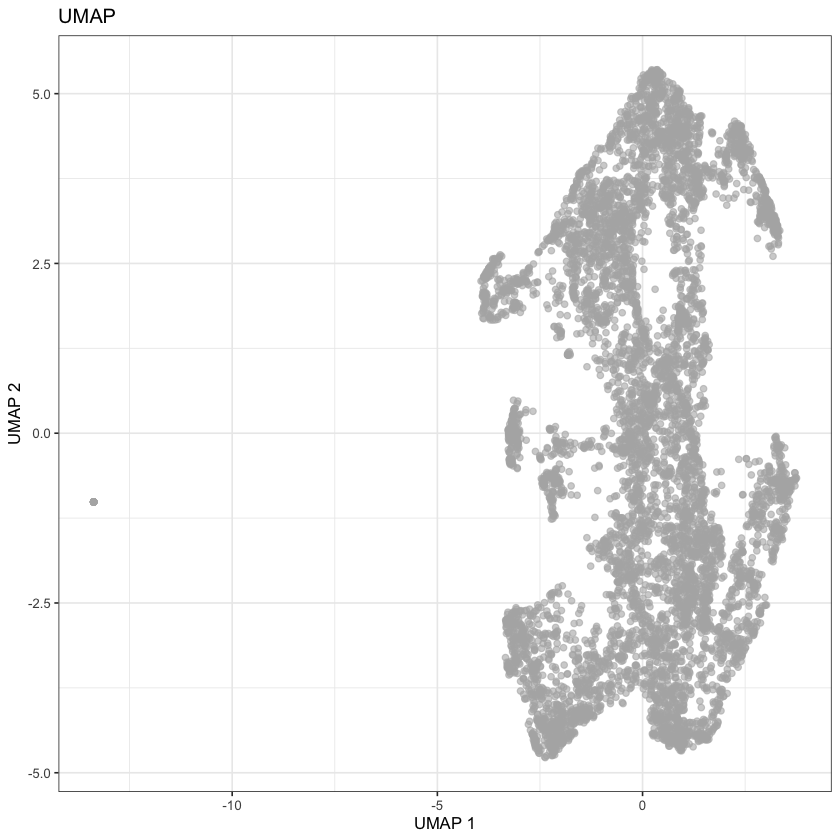

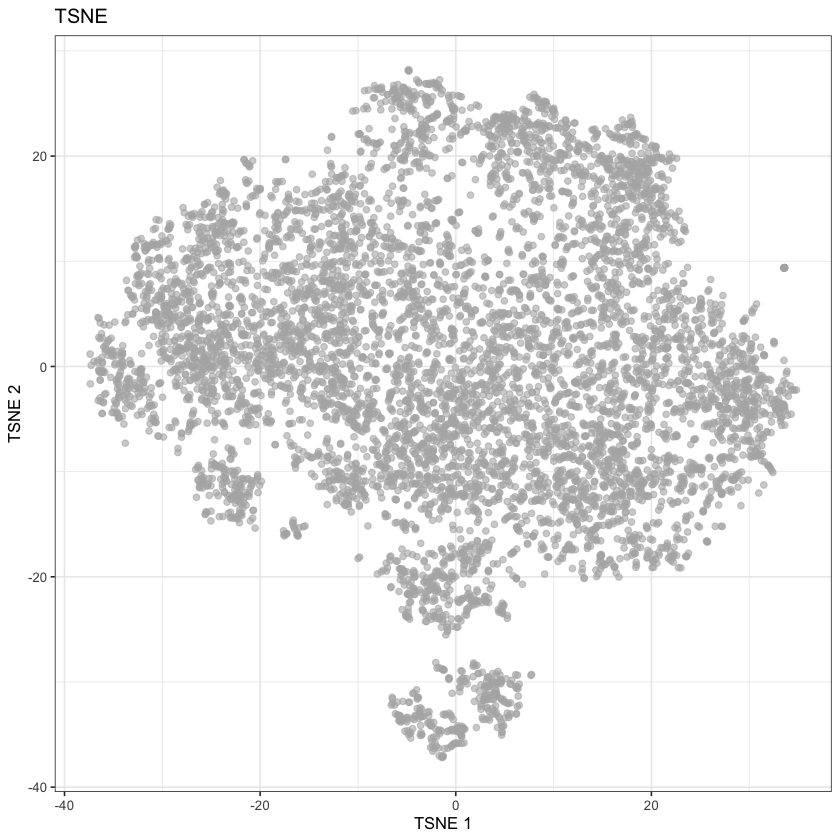

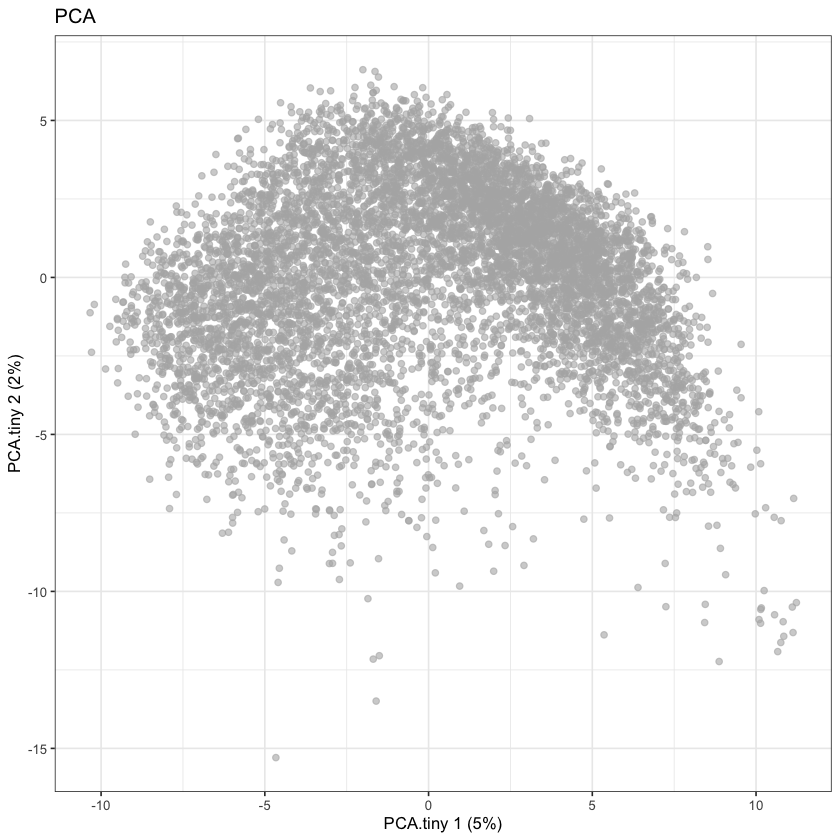

In [189]:
plotReducedDim(sce, dimred='UMAP') + ggtitle("UMAP")
plotReducedDim(sce, dimred='TSNE') + ggtitle("TSNE")
plotReducedDim(sce, dimred='PCA.tiny') + ggtitle("PCA")

None of these look great, but they do seem comparable to the UMAP reported by the Single Cell Expression Atlas:

![](./images/chicken-cell-umap-prior.png)

We can cheat by coloring in the cells by the predicted cell types, to get a thumbnail for this post (ideally we'd like to learn how to predict these ourselves).

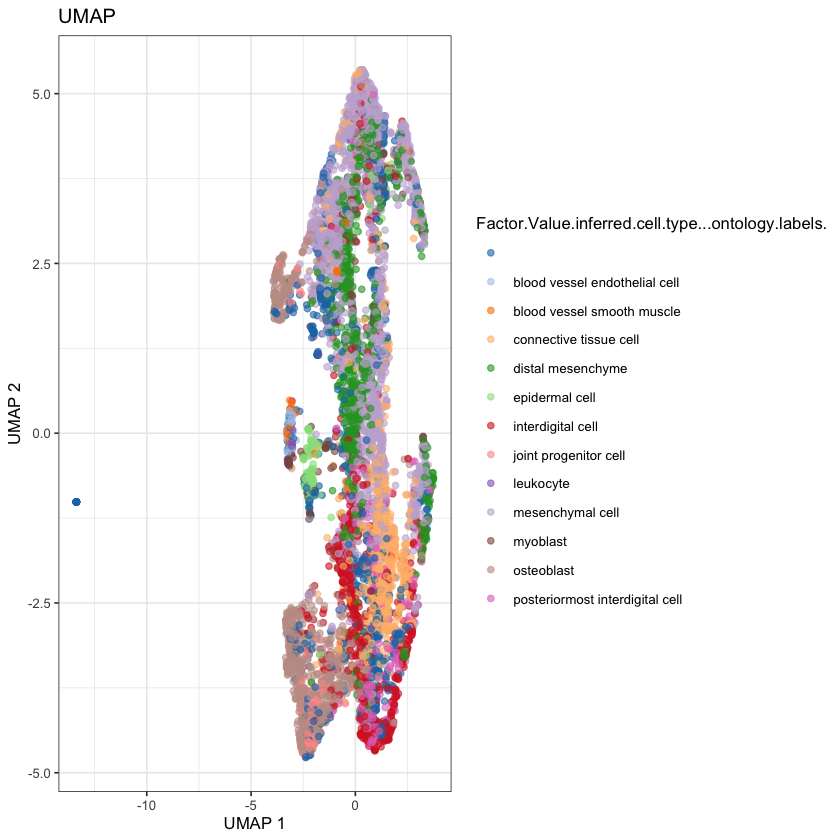

In [197]:
plotReducedDim(
    sce,
    dimred='UMAP',
    color_by="Factor.Value.inferred.cell.type...ontology.labels."
) + ggtitle("UMAP")